In [1]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.maze_tree_policy_renderer import render_tree_policy
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def create_meta_env(seed=0, enable_rendering=False):
    object_env = make_maze_env(
        seed=seed, maze_size=(5, 5), goal_reward=1,
        generate_new_maze_on_reset=True, enable_render=enable_rendering
    )

    q_hat = ManhattanQHat(object_env)
    extract_state = RestrictedActionsMazeState.extract_state(object_env)
    initial_tree = SearchTree(object_env, extract_state, q_hat)
    meta_env = MetaEnv(object_env, initial_tree, max_tree_size=32,
                       tree_policy_renderer=render_tree_policy,
                       split_mask_and_tokens=True,
                       one_hot_action_space=False,
                       expand_all_actions=True,
                       finish_on_terminate=True,
                       object_action_to_string=lambda a: object_env.ACTION[a])
    return meta_env

In [3]:
from mlrl.utils.render_utils import create_random_policy_video, embed_mp4
meta_env = BatchedPyEnvironment([
    GymWrapper(create_meta_env(enable_rendering=True)) for _ in range(2)
], multithreading=True)
embed_mp4(create_random_policy_video(meta_env, max_steps=10, rewrite_rewards=True))

In [4]:
from mlrl.utils.render_utils import create_policy_eval_video

from mlrl.meta.meta_env import mask_token_splitter
from tf_agents.policies.random_tf_policy import RandomTFPolicy

env = TFPyEnvironment(BatchedPyEnvironment([
    GymWrapper(create_meta_env(enable_rendering=True)) for _ in range(2)
], multithreading=True))

policy = RandomTFPolicy(env.time_step_spec(),
                        env.action_spec(),
                        observation_and_action_constraint_splitter=mask_token_splitter)

frames = create_policy_eval_video(policy, env, max_steps=30, rewrite_rewards=False, max_envs_to_show=2)

In [7]:
from mlrl.utils.render_utils import _create_rewritten_frames

In [49]:
from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter

batch_size = 2
env = BatchedPyEnvironment([
    GymWrapper(create_meta_env()) for _ in range(batch_size)
], multithreading=False)
env.reset()

data = []
rewards_rewriter = RetroactiveRewardsRewriter(env, data.append)

from tf_agents.trajectories.policy_step import PolicyStep
from tf_agents.trajectories import trajectory
import tensorflow as tf

for action in [[1, 1], [2, 0], [3, 1], [0, 1], [0, 2]]:
    action_step = PolicyStep(action=tf.convert_to_tensor(action), state=(), info=())
    time_step = env.current_time_step()
    next_time_step = env.step(action_step.action)

    action_step_with_previous_state = action_step._replace(state=())
    traj = trajectory.from_transition(time_step, action_step_with_previous_state, next_time_step)
    
    len_data = len(data)
    rewards_rewriter(traj)

    if len(data) > len_data:
        print("Rewards rewriter added data on action", action)

Rewards rewriter added data on action [0, 1]


In [16]:
from mlrl.experiments.ppo_runner import create_search_ppo_agent
from mlrl.experiments.experiment_utils import create_parser

batch_size = 8
env = BatchedPyEnvironment([
    GymWrapper(create_meta_env()) for _ in range(batch_size)
], multithreading=True)

parser = create_parser()
config = vars(parser.parse_args(args=[]))
agent = create_search_ppo_agent(env, config)

from tf_agents.policies import py_tf_eager_policy

policy = py_tf_eager_policy.PyTFEagerPolicy(
            agent.collect_policy, use_tf_function=True, batch_time_steps=False)

from tf_agents.drivers.py_driver import PyDriver
from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter
from tf_agents.replay_buffers import tf_uniform_replay_buffer


replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size or 1,
    max_length=10000
)

rewards_rewriter = RetroactiveRewardsRewriter(env, replay_buffer.add_batch)
py_driver = PyDriver(env, policy, observers=[rewards_rewriter], max_steps=100)

In [17]:
policy_state = policy.get_initial_state(env.batch_size or 1)
outputs = py_driver.run(env.reset(), policy_state)

In [18]:
def preprocess_seq(experience, info):
    return agent.preprocess_sequence(experience), info

def dataset_fn():
    ds = replay_buffer.as_dataset(sample_batch_size=32,
                                  num_steps=10)
    return ds.map(preprocess_seq).prefetch(5)

In [19]:
ds = dataset_fn()

In [ ]:
batch_size = 2
env = BatchedPyEnvironment([
    GymWrapper(create_meta_env()) for _ in range(batch_size)
], multithreading=False)

In [7]:
max_steps = 100

def time_multithreading(batch_size, samples=3):

    times = []
    for i in range(samples):
        env = BatchedPyEnvironment([
            GymWrapper(create_meta_env()) for _ in range(batch_size)
        ], multithreading=True)

        from mlrl.experiments.ppo_runner import create_search_ppo_agent
        from mlrl.experiments.experiment_utils import create_parser

        parser = create_parser()
        config = vars(parser.parse_args(args=[]))

        agent = create_search_ppo_agent(env, config)

        from tf_agents.policies import py_tf_eager_policy

        policy = py_tf_eager_policy.PyTFEagerPolicy(
                    agent.collect_policy, use_tf_function=True, batch_time_steps=False)

        from tf_agents.drivers.py_driver import PyDriver
        from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter

        data = []
        rewards_rewriter = RetroactiveRewardsRewriter(env, data.append)
        py_driver = PyDriver(env, policy, observers=[rewards_rewriter], max_steps=max_steps)

        policy_state = policy.get_initial_state(env.batch_size or 1)

        import time
        start = time.time()
        py_driver.run(env.reset(), policy_state)
        end = time.time()
        times.append(end - start)
        print(f"Trial {i}: Batch size {batch_size} took {end - start:.3f} seconds")

    import numpy as np
    print(f"Batch size {batch_size} took a mean of {np.mean(times):.3f} +/- {np.std(times):.3f} seconds")

for batch_size in [1, 2, 4, 8, 16]:
    time_multithreading(batch_size)

Trial 0: Batch size 1 took 6.876 seconds
Trial 1: Batch size 1 took 6.983 seconds
Trial 2: Batch size 1 took 6.893 seconds
Batch size 1 took a mean of 6.917 +/- 0.047 seconds
Trial 0: Batch size 2 took 5.119 seconds
Trial 1: Batch size 2 took 4.846 seconds
Trial 2: Batch size 2 took 5.824 seconds
Batch size 2 took a mean of 5.263 +/- 0.412 seconds
Trial 0: Batch size 4 took 3.587 seconds
Trial 1: Batch size 4 took 3.961 seconds
Trial 2: Batch size 4 took 4.009 seconds
Batch size 4 took a mean of 3.852 +/- 0.189 seconds
Trial 0: Batch size 8 took 3.444 seconds
Trial 1: Batch size 8 took 3.627 seconds
Trial 2: Batch size 8 took 3.561 seconds
Batch size 8 took a mean of 3.544 +/- 0.076 seconds
Trial 0: Batch size 16 took 4.942 seconds
Trial 1: Batch size 16 took 4.117 seconds
Trial 2: Batch size 16 took 4.170 seconds
Batch size 16 took a mean of 4.410 +/- 0.377 seconds


In [11]:
def main():
    env = BatchedPyEnvironment([
        GymWrapper(create_meta_env())
    ], multithreading=False)

    from mlrl.experiments.ppo_runner import create_search_ppo_agent
    from mlrl.experiments.experiment_utils import create_parser

    parser = create_parser()
    config = vars(parser.parse_args(args=[]))

    agent = create_search_ppo_agent(env, config)

    from tf_agents.policies import py_tf_eager_policy

    policy = py_tf_eager_policy.PyTFEagerPolicy(
                agent.collect_policy, use_tf_function=True, batch_time_steps=False)

    from tf_agents.drivers.py_driver import PyDriver
    from mlrl.meta.retro_rewards_rewriter import RetroactiveRewardsRewriter

    data = []
    rewards_rewriter = RetroactiveRewardsRewriter(env, agent.collect_data_spec, data.append)
    py_driver = PyDriver(env, policy, observers=[rewards_rewriter], max_steps=100)

    policy_state = policy.get_initial_state(env.batch_size or 1)

    py_driver.run(env.reset(), policy_state)


import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
main()
profiler.disable()

In [12]:
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

         3329060 function calls (3249220 primitive calls) in 8.379 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    8.380    4.190 /usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3361(run_code)
        2    0.000    0.000    8.380    4.190 {built-in method builtins.exec}
        1    0.002    0.002    8.380    8.380 /tmp/ipykernel_15461/3639192703.py:34(<cell line: 34>)
        1    0.001    0.001    8.355    8.355 /tmp/ipykernel_15461/3639192703.py:1(main)
        1    0.014    0.014    7.760    7.760 /usr/local/lib/python3.8/dist-packages/tf_agents/drivers/py_driver.py:89(run)
7996/2406    0.015    0.000    7.018    0.003 /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/traceback_utils.py:138(error_handler)
      146    0.003    0.000    6.671    0.046 /usr/local/lib/python3.8/dist-packages/tf_agents/policies/py_policy.py:140(action)
      146    0.002  

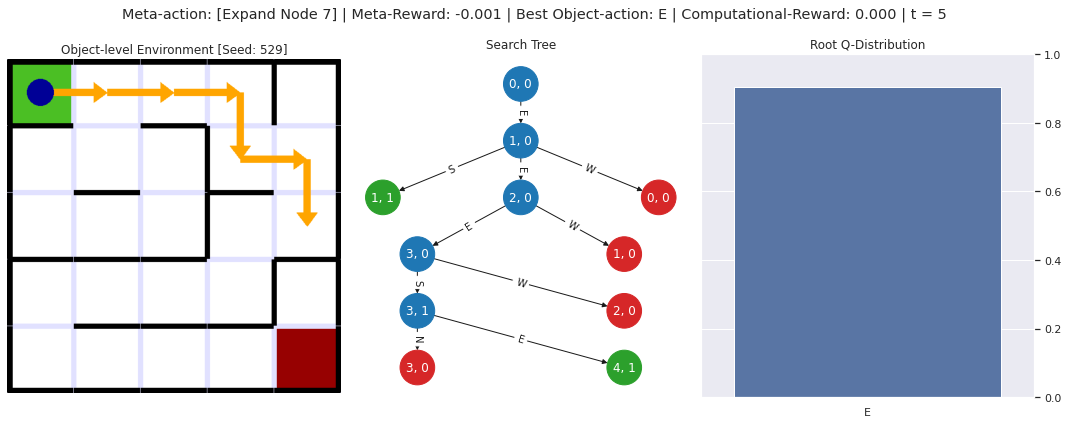

Estimating value of new policy:
 {MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.004]--> (MazeState(1, 1))
	|---[E, -0.004]--> {MazeState(2, 0)}
		|---[E, -0.004]--> {MazeState(3, 0)}
			|---[S, -0.004]--> {MazeState(3, 1)}
				|---[N, -0.004]--> {MazeState(3, 0)}
				|---[E, -0.004]--> {MazeState(4, 1)}
					|---[N, -0.004]--> (MazeState(4, 0))
					|---[S, -0.004]--> (MazeState(4, 2))
					|---[W, -0.004]--> {MazeState(3, 1)}
			|---[W, -0.004]--> {MazeState(2, 0)}
		|---[W, -0.004]--> {MazeState(1, 0)}
	|---[W, -0.004]--> {MazeState(0, 0)}
P(E | MazeState(0, 0)) = 1.0
P(S | MazeState(1, 0)) = 1.0
P(E | MazeState(1, 1)) = 1.0
Leaf evaluation: Q-hat(MazeState(1, 1), E) = 0.93139
Value(MazeState(1, 1)) = 0.93139
Recursive Q-hat(MazeState(1, 0), S) = 0.918 
Value(MazeState(1, 0)) = 0.91807
Recursive Q-hat(MazeState(0, 0), E) = 0.905 
Value(MazeState(0, 0)) = 0.90489

Estimating value of prior policy:
 {MazeState(0, 0)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.

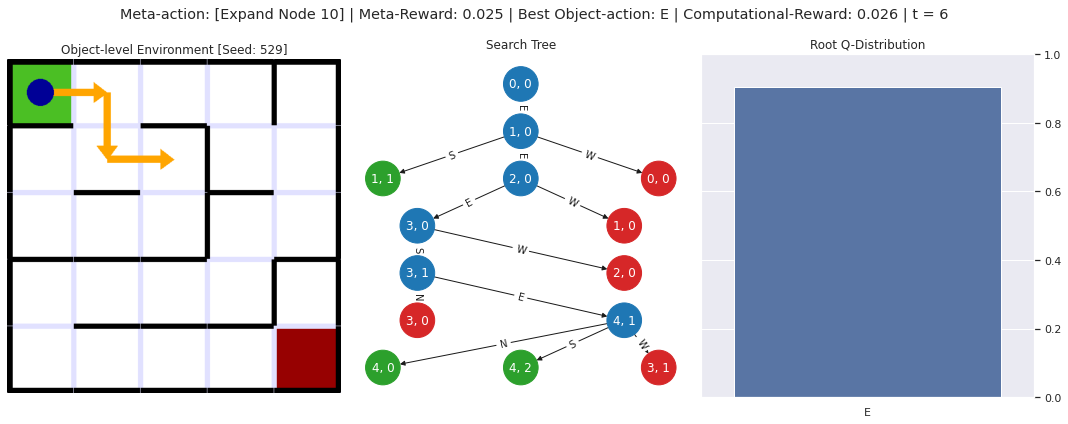

In [7]:
meta_env = create_meta_env(seed=529)
for a in [1, 2, 4, 6, 8]:
    meta_env.step(a)
meta_env.render(plt_show=True)
meta_env.step(11, verbose=True)
meta_env.render(plt_show=True);

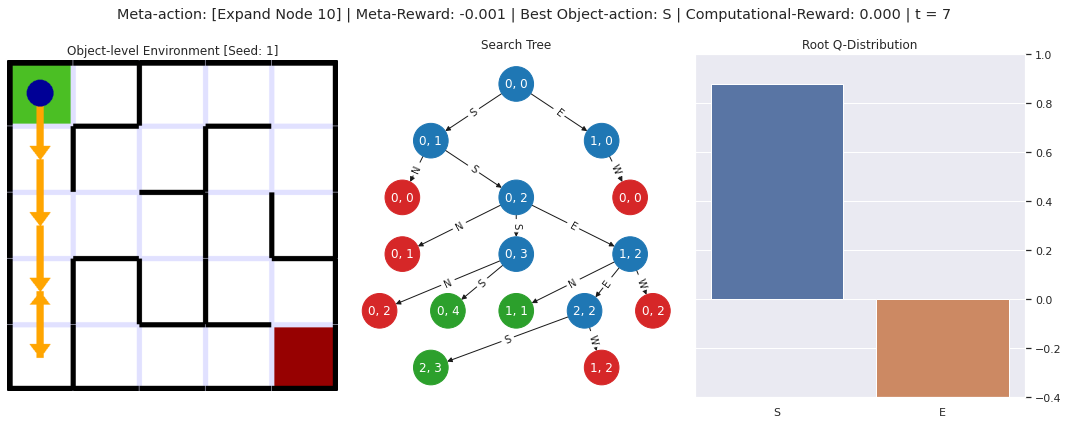

Estimating value of new policy:
 {MazeState(0, 0)}
|---[S, -0.004]--> {MazeState(0, 1)}
	|---[N, -0.004]--> {MazeState(0, 0)}
	|---[S, -0.004]--> {MazeState(0, 2)}
		|---[N, -0.004]--> {MazeState(0, 1)}
		|---[S, -0.004]--> {MazeState(0, 3)}
			|---[N, -0.004]--> {MazeState(0, 2)}
			|---[S, -0.004]--> {MazeState(0, 4)}
				|---[N, -0.004]--> {MazeState(0, 3)}
		|---[E, -0.004]--> {MazeState(1, 2)}
			|---[N, -0.004]--> (MazeState(1, 1))
			|---[E, -0.004]--> {MazeState(2, 2)}
				|---[S, -0.004]--> (MazeState(2, 3))
				|---[W, -0.004]--> {MazeState(1, 2)}
			|---[W, -0.004]--> {MazeState(0, 2)}
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[W, -0.004]--> {MazeState(0, 0)}
P(S | MazeState(0, 0)) = 1.0
P(S | MazeState(0, 1)) = 1.0
P(E | MazeState(0, 2)) = 1.0
P(N | MazeState(1, 2)) = 1.0
P(S | MazeState(1, 1)) = 1.0
Leaf evaluation: Q-hat(MazeState(1, 1), S) = 0.93139
Value(MazeState(1, 1)) = 0.93139
Recursive Q-hat(MazeState(1, 2), N) = 0.918 
Value(MazeState(1, 2)) = 0.91807
Recursive Q-

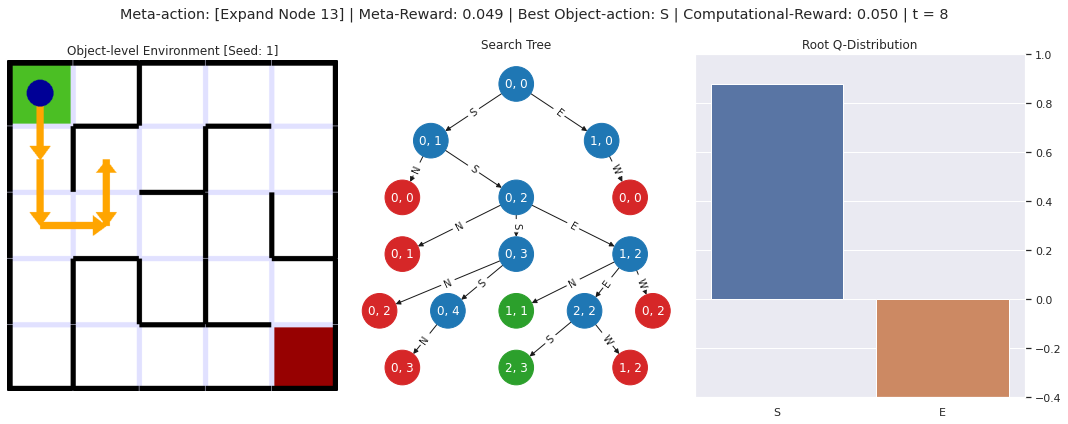

In [8]:
meta_env = create_meta_env(seed=1)
for a in [1, 2, 5, 3, 8, 7, 11]:
    meta_env.step(a)
meta_env.render(plt_show=True)
meta_env.step(14, verbose=True)
meta_env.render(plt_show=True);

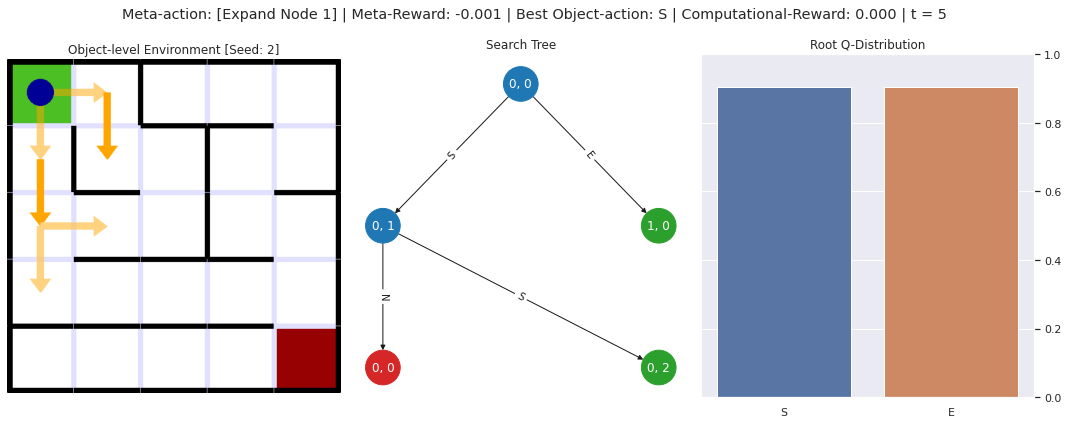

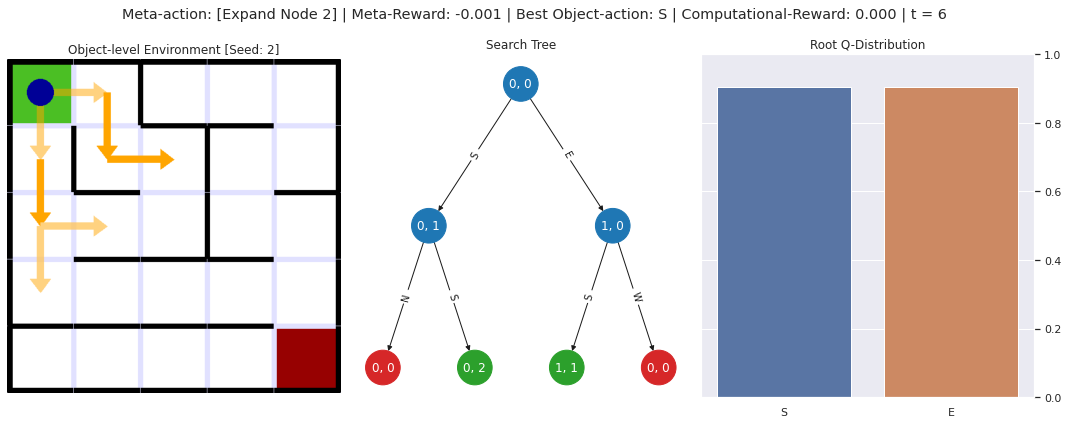

Estimating value of new policy:
 {MazeState(0, 0)}
|---[S, -0.004]--> {MazeState(0, 1)}
	|---[N, -0.004]--> {MazeState(0, 0)}
	|---[S, -0.004]--> (MazeState(0, 2))
|---[E, -0.004]--> {MazeState(1, 0)}
	|---[S, -0.004]--> (MazeState(1, 1))
	|---[W, -0.004]--> {MazeState(0, 0)}
Waiting for debugger attach


KeyboardInterrupt: 

In [4]:
meta_env = create_meta_env()
meta_env.reset()
meta_env.reset()

for i in range(3):
    meta_env.step(0)
meta_env.step(1)
# meta_env.render(plt_show=True);
meta_env.step(2)
# meta_env.step(4)
# meta_env.step(5)
# meta_env.step(0)
meta_env.render(plt_show=True);
meta_env.step(3)
# meta_env.step(9, verbose=True)
meta_env.render(plt_show=True);
meta_env.step(7, verbose=True)
meta_env.render(plt_show=True);


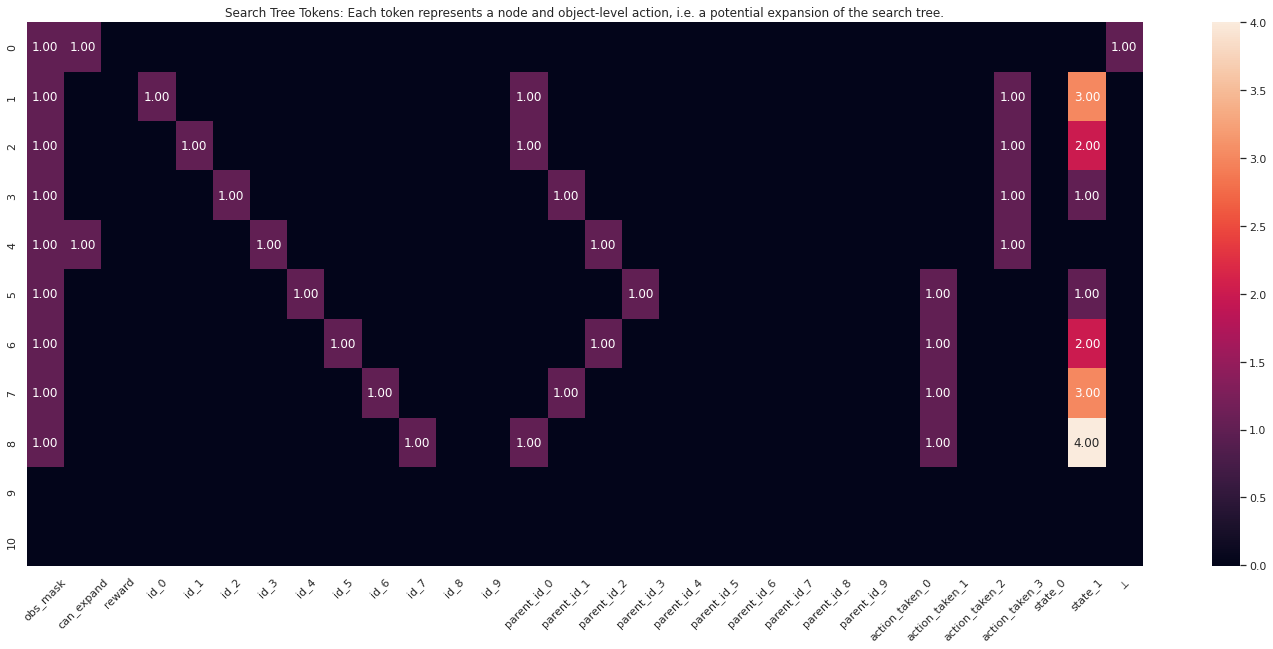

In [8]:
meta_env.plot_search_tokens(annot_fmt='.2f')

In [3]:
import numpy as np
env.reset()

for _ in range(8):
    actions = env.current_time_step().observation['valid_action_mask'].numpy()[0]
    actions[0] = 0
    action = np.random.choice(np.arange(len(actions)), p=actions/actions.sum())
    env.step(action)

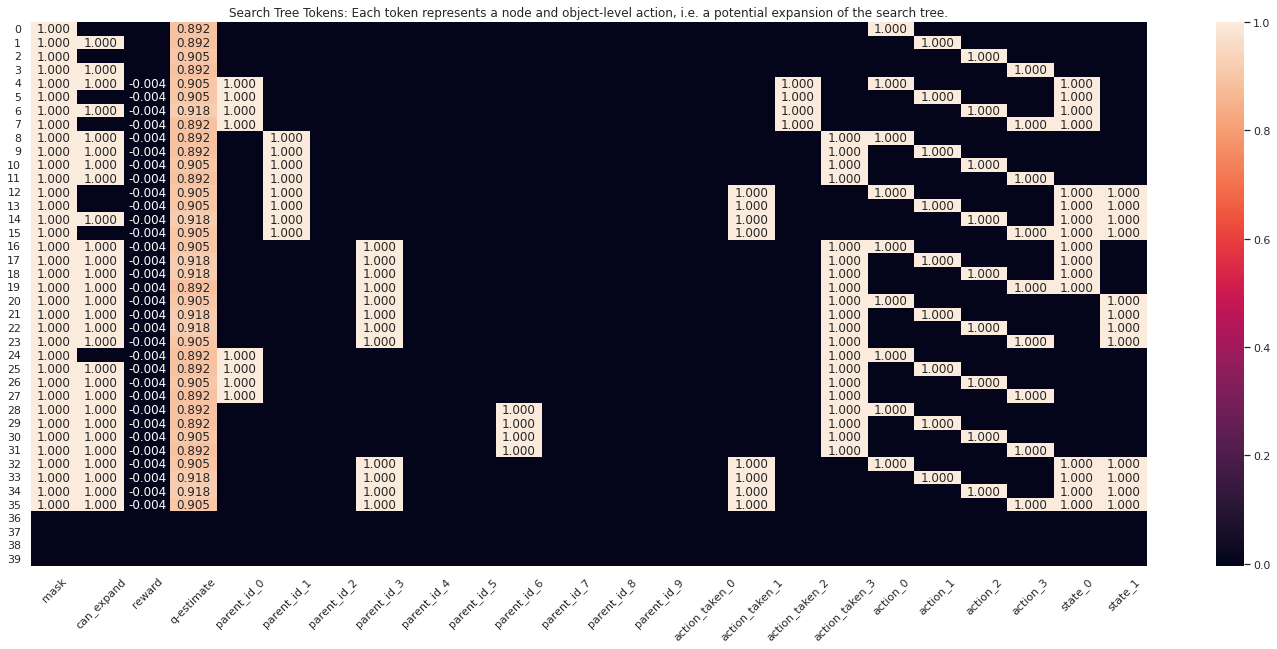

In [5]:
meta_env.plot_search_tokens()

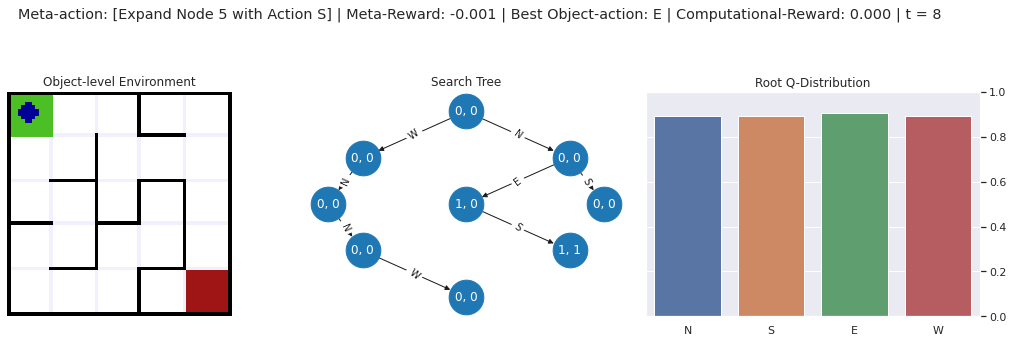

In [15]:
meta_env.render(plt_show=True);

In [6]:
def mask_invalid_action_constraint_splitter(observation):
    return observation['search_tree_tokens'], observation['valid_action_mask']


from mlrl.meta.search_q_model import SearchQModel

import tensorflow as tf
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.utils import common
from tf_agents.specs import tensor_spec


# weights_path = './runs/dqn_agent/simple_single_grid_dqn-16638260065752182/model'
weights_path = './q_net.h5'

q_net = SearchQModel()
q_net(env.current_time_step().observation['search_tree_tokens'])  # build the model
q_net.load_weights(weights_path)

optimizer = tf.keras.optimizers.Adam(learning_rate=0)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=sequential.Sequential([q_net]),
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter,
    train_step_counter=train_step_counter
)

agent.initialize()

INFO:tensorflow:Assets written to: ram://283d7ece-269a-430b-b92c-2755512c6bb3/assets


INFO:tensorflow:Assets written to: ram://283d7ece-269a-430b-b92c-2755512c6bb3/assets


In [7]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(agent.policy, env, max_steps=30))

In [9]:
q_net.q_network.summary()

Model: "q_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10, 192)           3648      
                                                                 
 reshape_1 (Reshape)         (None, 40, 48)            0         
                                                                 
 prepend_terminate_token_1 (  (None, 41, 48)           0         
 PrependTerminateToken)                                          
                                                                 
 transformer_2 (Transformer)  (None, 41, 48)           11200     
                                                                 
 transformer_3 (Transformer)  (None, 41, 48)           11200     
                                                                 
 dense_3 (Dense)             (None, 41, 1)             49        
                                                         

## With Restricted Actions

In [14]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper


object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64),
    generate_new_maze_on_reset=False
)

q_hat = ManhattanQHat(object_env)
init_state = RestrictedActionsMazeState.extract_state(object_env)
initial_tree = SearchTree(object_env, init_state, q_hat)
meta_env = MetaEnv(object_env, initial_tree, max_tree_size=10, 
                   object_action_to_string=lambda a: object_env.ACTION[a])

env = TFPyEnvironment(GymWrapper(meta_env))


In [15]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from mlrl.meta.meta_env import mask_invalid_action_constraint_splitter

random_policy = RandomTFPolicy(
    env.time_step_spec(),
    env.action_spec(),
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter
)

In [3]:
from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(random_policy, env, max_steps=300))

In [16]:
random_policy.action(env.current_time_step()).action

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>

In [17]:
env.reset()
for _ in range(10):
    a = random_policy.action(env.current_time_step()).action[0]
    if a == 0:
        continue
    env.step(a)

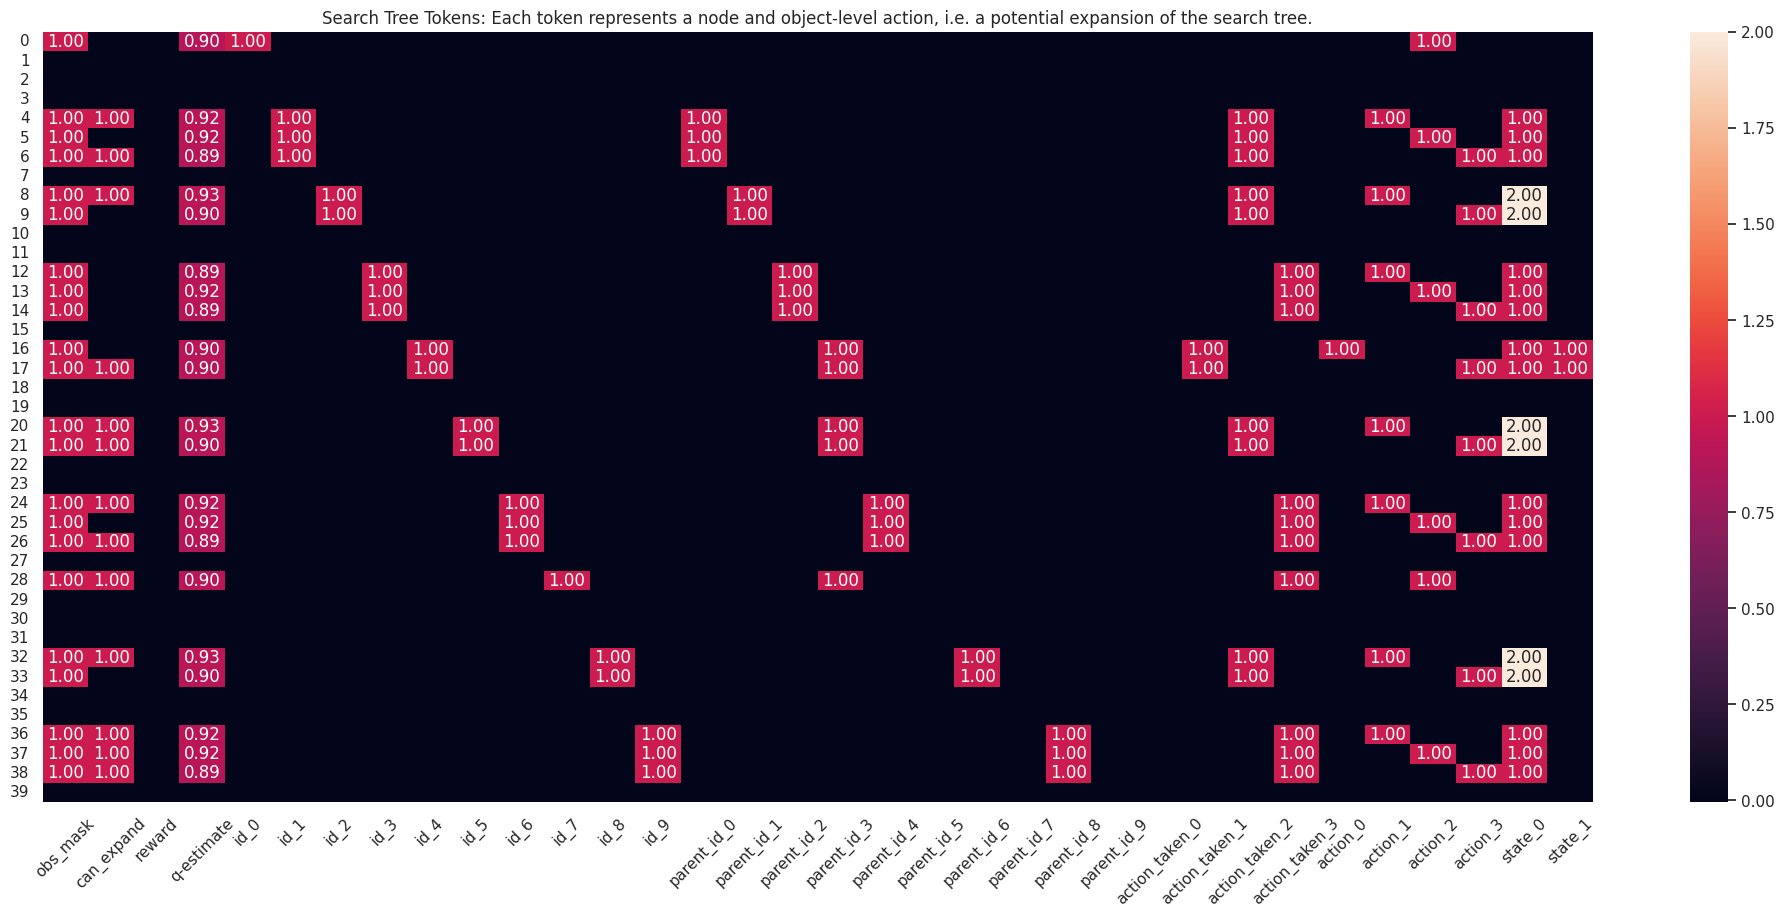

In [22]:
meta_env.plot_search_tokens(annot_fmt='.2f')

## Reward Distributions

In [ ]:
from mlrl.maze.maze_env import make_maze_env
from mlrl.maze.maze_state import RestrictedActionsMazeState
from mlrl.meta.search_tree import SearchTree
from mlrl.meta.meta_env import MetaEnv
from mlrl.maze.manhattan_q import ManhattanQHat

from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper


object_env = make_maze_env(
    seed=0, maze_size=(5, 5), goal_reward=1, render_shape=(64, 64),
    generate_new_maze_on_reset=False
)

q_hat = ManhattanQHat(object_env)
init_state = RestrictedActionsMazeState.extract_state(object_env)
initial_tree = SearchTree(object_env, init_state, q_hat)
meta_env = MetaEnv(object_env, initial_tree, max_tree_size=10, 
                   object_action_to_string=lambda a: object_env.ACTION[a])

env = TFPyEnvironment(GymWrapper(meta_env))

In [10]:
from tf_agents.policies import TFPolicy
from tf_agents.environments.tf_environment import TFEnvironment
import numpy as np


def compute_return_stats(environment: TFEnvironment,
                         policy: TFPolicy,
                         num_episodes: int = 3,
                         max_steps: int = 100) -> float:
    """
    Computes mean and standard deviation for returns of a policy on a given environment.
    """

    returns = []
    rewards = []
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0
        n_steps = 0
        while not time_step.is_last() and n_steps < max_steps:
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            rewards.append(time_step.reward.numpy()[0])
            n_steps += 1

        returns.append(episode_return)

    returns = np.array(returns)

    return returns.mean(), returns.std(), rewards

In [11]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from mlrl.meta.meta_env import mask_invalid_action_constraint_splitter

random_policy = RandomTFPolicy(
    env.time_step_spec(),
    env.action_spec(),
    observation_and_action_constraint_splitter=mask_invalid_action_constraint_splitter
)

In [43]:
mean_return, return_std, rewards = compute_return_stats(env, random_policy, num_episodes=20)

In [45]:
rewards = [r.numpy()[0] for r in rewards]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


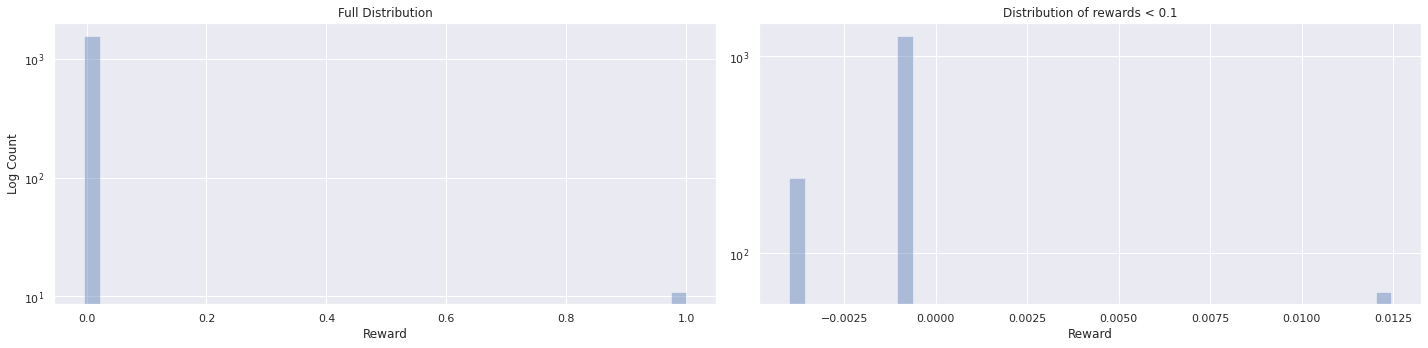

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

t = 0.1

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(rewards, ax=axs[0], kde=False)
sns.distplot([r for r in rewards if r < t], ax=axs[1], kde=False)

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel('Reward')

axs[0].set_ylabel('Log Count')
axs[1].set_ylabel('')
axs[0].set_title('Full Distribution')
axs[1].set_title(f'Distribution of rewards < {t}')
plt.tight_layout()
plt.show()